# SD-TSIA210 - Machine Learning
## Seoul Bike Rental Analysis
### Group 2: 

*   Ferreira Torres, Bernardo
*   Morina, Alessandro
*   Souza Pinto Medeiros, Gabriel
*   Togashi De Miranda, Júlia

# Initializing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:

# Challenge data has been uploaded to the Google drive

if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1aoj8GUhyA72IZKQ4UY0cgrcHXHk7gvZs',
                                      dest_path='./SeoulBikeData.csv')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Modify working_dir if you are not using Google Colab)
Working_directory="./"  

In [ ]:
#Loading classes for each image in training dataset
df = pd.read_csv("SeoulBikeData.csv", encoding='iso-8859-1')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# Data exploration

### Data presentation
Date : year-month-day 

Rented Bike count - Count of bikes rented at each hour 

Hour - Hour of the day 

Temperature-Temperature in Celsius 

Humidity - % 

Windspeed - m/s 

Visibility - 10m 

Dew point temperature - Celsius 

Solar radiation - MJ/m2 

Rainfall - mm 

Snowfall - cm 

Seasons - Winter, Spring, Summer, Autumn 

Holiday - Holiday/No holiday 

Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

### Missing values and correlation

First, we try to find any eventual missing data and treat it.

In [ ]:
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Luckily, there isn't any missing data

Now we will take a look at the descriptive statistics in order to better understand what is going on

In [ ]:
df.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


We can see that rainfall and snowfall are sparse in Seoul, since even at 75% its value is 0. We can also observe the strange variable that is dew point temperature, when higher than 29, it is known to cause death due to hiperthermia, and at the maximum value of 27 we observed in Seoul it will cause severe discomfort and possibly even death to people with asma and related diseases. 

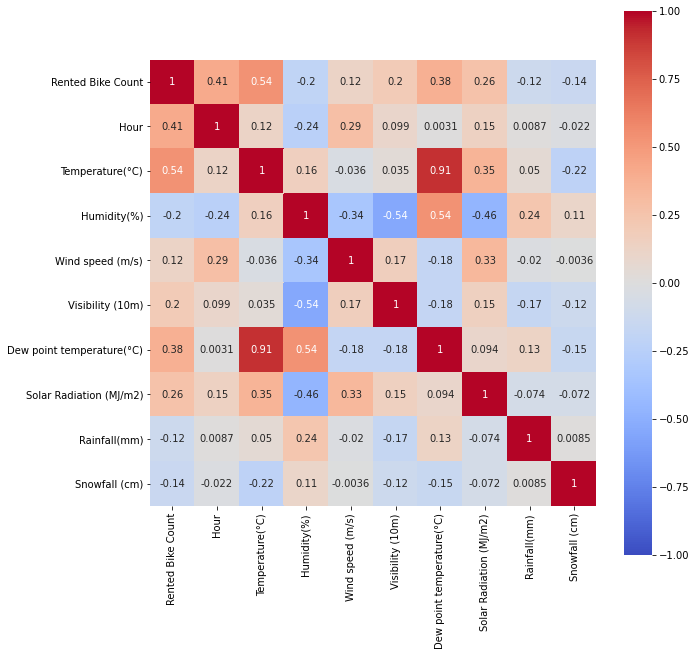

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, square=True)
plt.show()

We can see a sizeable correlation with temperature and Dew point temperature, which is the temperature needed on that day for water to condense. Since temperature has a higher correlation with the target variable we will drop the dew point feature.

In order to proceed we will need to change a few variables:

Hour: it should not be a very straightforward variable, and as such it might be best to divide it in morning day and night

Seasons: dummy variables should be created from it

Functioning day and holiday: should be both binary

Date: should be transformed to a binary variable that contains weekend.

Dew point: drop


### Hour

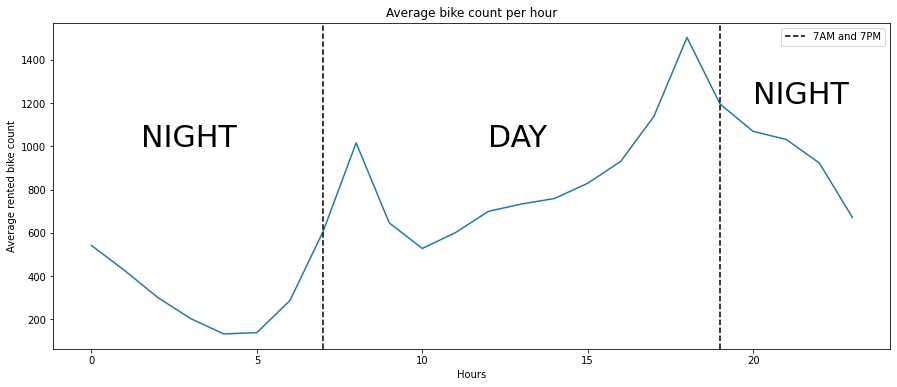

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Average bike count per hour')
plt.ylabel('Average rented bike count')
plt.xlabel('Hours')
plt.plot(df.groupby('Hour').mean()['Rented Bike Count'])
plt.axvline(7, color='black', ls='--', label='7AM and 7PM')
plt.axvline(19, color='black', ls='--')
plt.text(12, 1000, 'DAY', fontsize=30)
plt.text(1.5, 1000, 'NIGHT', fontsize=30)
plt.text(20, 1200, 'NIGHT', fontsize=30)
plt.legend()
plt.show()

We can clearly see that people tend to rent more during the day than during the night, but early night still carries a high momentum from the end of the day, so perhaps a division that separates morning would be best. 

In [ ]:
df.loc[df.Hour<=7, 'Morning']=1
df.loc[df.Hour>7, 'Morning']=0
#df = df.drop(['Hour'], axis=1)

### Seasons

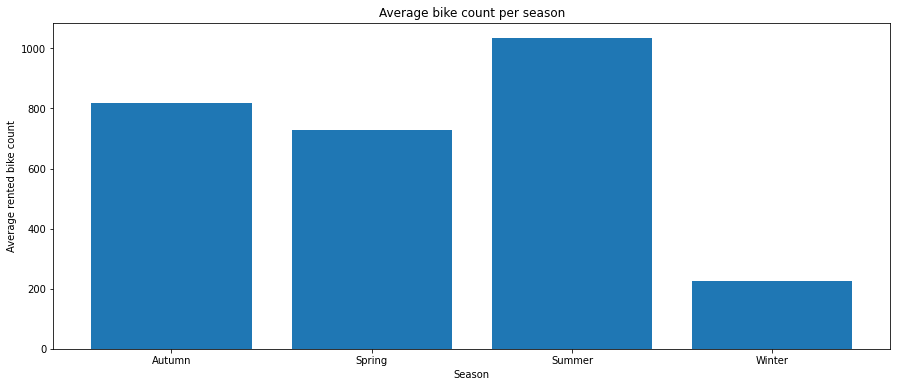

In [ ]:
plt.figure(figsize=(15,6))
plt.title('Average bike count per season')
plt.ylabel('Average rented bike count')
plt.xlabel('Season')
seasons = df.groupby('Seasons').mean()['Rented Bike Count']
plt.bar(['Autumn', 'Spring', 'Summer', 'Winter'], seasons)
plt.show()

We can observe that there are far fewer rentals in the winter when compared to the other seasons, with summer beating out the others by a slight margin. In order to incorporate this information into the regressions we will create dummy variables for the four seasons

In [ ]:
df = pd.get_dummies(df, columns=['Seasons'])

### Functional day and Holiday

In [ ]:
df['Holiday'].replace({'Holiday':1, 'No Holiday':0}, inplace=True)
df['Functioning Day'].replace({'Yes':1, 'No':0}, inplace=True)

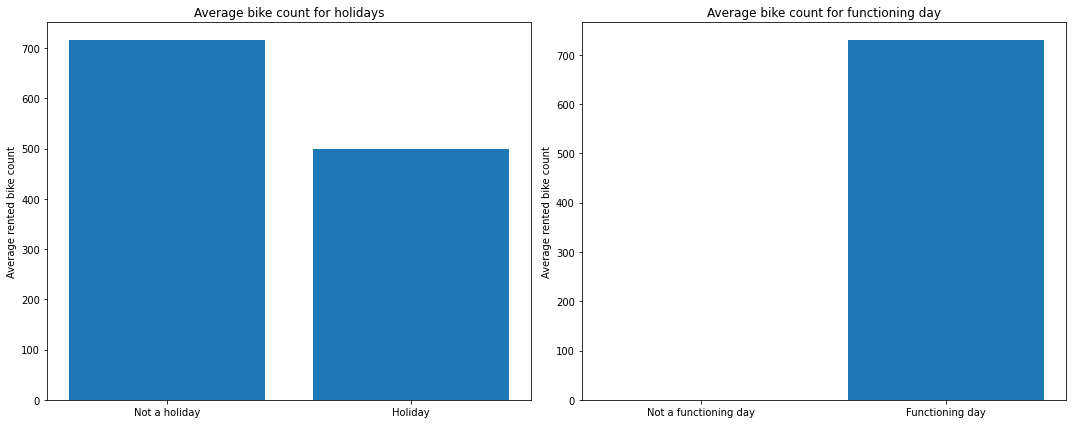

In [ ]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.title('Average bike count for holidays')
plt.ylabel('Average rented bike count')
holiday = df.groupby('Holiday').mean()['Rented Bike Count']
plt.bar(['Not a holiday', 'Holiday',], holiday)

plt.subplot(122)
plt.title('Average bike count for functioning day')
plt.ylabel('Average rented bike count')
holiday = df.groupby('Functioning Day').mean()['Rented Bike Count']
plt.bar(['Not a functioning day', 'Functioning day',], holiday)

plt.tight_layout()
plt.show()

From these graphs we can conclude two things, first of all people tend to rent bikes less on holidays. Perhaps they use them as a means of transportation for their daily lives and less for tourism. Secondly, it confirms that "functioning" refers to the store, and for some reason they included the amount of days they aren't open into the data. Obviously if the store is closed they will have 0 rented bikes.

In [ ]:
aux = df.loc[df['Functioning Day']==0, 'Rented Bike Count'].sum()
print(f'The total amount of bikes loaned on non-functioning days is: {aux}')

The total amount of bikes loaned on non-functioning days is: 0


### Date

In [ ]:
df['Date']=pd.to_datetime(df['Date'])

In [ ]:
df['Weekday']=df["Date"].dt.day_name()
wknd = (df.Weekday=='Saturday')|(df.Weekday=='Sunday')
df.loc[wknd, 'Weekend']=1
df.loc[~wknd, 'Weekend']=0

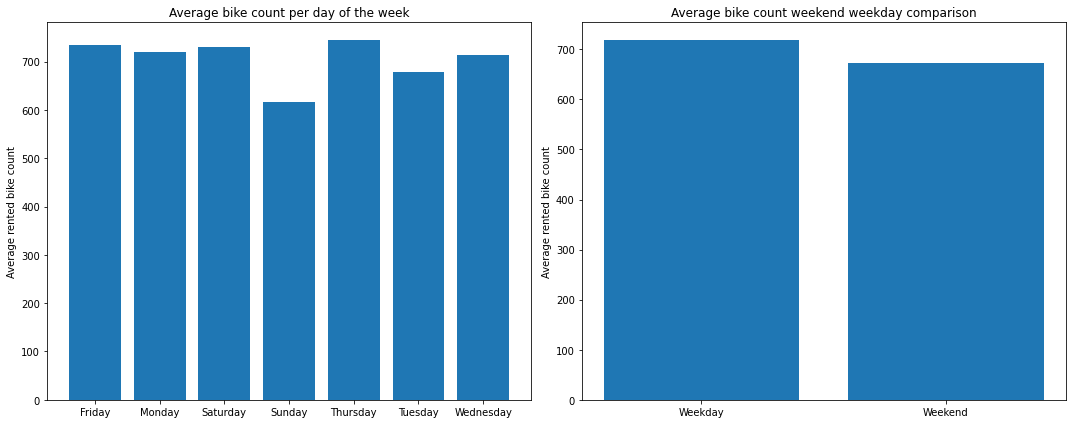

In [ ]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.title('Average bike count per day of the week')
plt.ylabel('Average rented bike count')
days = df.groupby('Weekday').mean()['Rented Bike Count']
plt.bar(days.index, days)

plt.subplot(122)
plt.title('Average bike count weekend weekday comparison')
plt.ylabel('Average rented bike count')
wknd = df.groupby('Weekend').mean()['Rented Bike Count']
plt.bar(['Weekday', 'Weekend'], wknd)


plt.tight_layout()
plt.show()

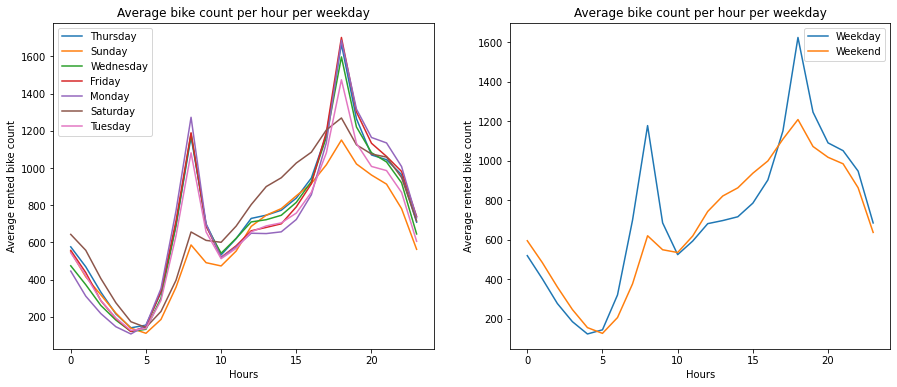

In [ ]:
plt.subplots(1, 2, figsize=(15,6))
plt.subplot(121)
plt.title('Average bike count per hour per weekday')
plt.ylabel('Average rented bike count')
plt.xlabel('Hours')
for i in df['Weekday'].unique():
  plt.plot(df[df.Weekday==i].groupby('Hour').mean()['Rented Bike Count'], label=i)
plt.legend()

plt.subplot(122)
plt.title('Average bike count per hour per weekday')
plt.ylabel('Average rented bike count')
plt.xlabel('Hours')
plt.plot(df[df.Weekend==0].groupby('Hour').mean()['Rented Bike Count'], label='Weekday')
plt.plot(df[df.Weekend==1].groupby('Hour').mean()['Rented Bike Count'], label='Weekend')
plt.legend()

plt.show()

In [ ]:
df = pd.get_dummies(df, columns=['Weekday'])

We can't observe significant difference when we look at averages per day, but once we observe the average curves during each day differences emerge. Clearly Saturdays and Sundays have different curves at rush hours. This prompted us to create dummy variables for each day of the week and for weekends.

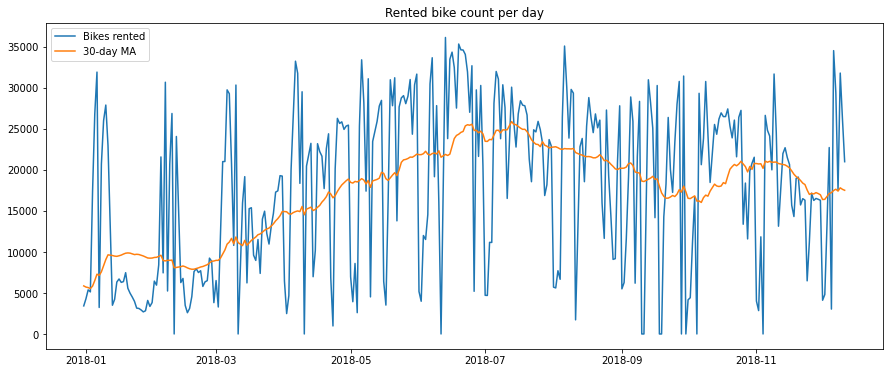

In [ ]:
plt.figure(figsize=(15, 6))
day_by_day = df.groupby('Date').sum()['Rented Bike Count']
plt.title('Rented bike count per day')
plt.plot(day_by_day.index[30:], day_by_day[30:], label='Bikes rented')
plt.plot(day_by_day.index[30:], day_by_day.rolling(30).mean()[30:], label='30-day MA')
plt.legend()
plt.show()

Here we can clearly observe the trends remarked previously, with the relative winter sales being low and eventually peaking in the summer. However, I believe that this might just be the business growing in 2018 and as such more data pertaining to really know if rentals are truly that low in the winter.

### Dropping variables

In [ ]:
df = df.drop(['Dew point temperature(°C)', 'Date'], axis=1)
#df_open = ((df.loc[df['Functioning Day']==1]).drop(['Functioning Day'], axis=1)).copy()

Finally, the final dataset was created.

# Regressions

### Creating train and test datasets

First we must divide our datasets into train and test in order to be able to avoid overfitting. Also, we decided to make two versions of X, one standardized and one not in order to observe any differences in results. To evaluate each regression's results we decided to use the commonly adopted $R^2$ metric.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
X = df.drop(['Rented Bike Count'], axis=1)
y = df['Rented Bike Count']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

regression_results = pd.DataFrame(columns=['Regression', 'R2_test', 'R2_train', 
                                           'MSE', 'MAE'])
regression_results = regression_results.set_index('Regression')

### Linear Regression

Firstly we started with a linear regression, where we would just plug in the features and see how accurate our prediction was and we obtained an $R^2$ of .55, which isn't bad for a linear regression. We tried to remove one of our binary features (Seasons_Spring) to avoid multicollinearity across the features but despite improving interpretability it didn't change the prediction result. Also standardizing seemed to not affect this regression.

In [ ]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression().fit(X_train_standard, y_train)

In [ ]:
print(f'The train score was: {linear.score(X_train_standard, y_train)}')
print(f'The test score was: {linear.score(X_test_standard, y_test)}')

The train score was: 0.5618192660109996
The test score was: 0.56148373034301


In [ ]:
regression_results.loc['Linear', :] = [linear.score(X_test_standard, y_test), 
                                       linear.score(X_train_standard, y_train),
                                       mse(y_test, linear.predict(X_test_standard)),
                                       mae(y_test, linear.predict(X_test_standard))]

In [ ]:
linear.coef_

array([  78.9030748 ,  326.61730669, -158.38807339,   14.48548284,
         18.05503766, -119.27542442,  -70.90118082,   11.44712491,
        -27.49050454,  167.91954639, -143.70587609,   67.47557929,
         20.52389551,    1.24024384,  -89.67465954,   -8.90288557,
          7.94458863,    8.14578517,    4.03823809,  -15.34196506,
         -1.80846163,   -8.74086327,    6.17254338])

### Lasso


We decided to apply the lasso regression to test out a supposition we had about the behaviour of the linear regression, that it should obtain a different result to the linear one. In the section above the coefficients obtained for the linear regression are big enough to warrant a regularization parameter and as such the Lasso regression was implemented. Our predictions were incorrect, and it didn't show a considerable improvement on the linear regression. To implement cross-validation, we used scikit's LassoCV. 

In [ ]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(eps=1e-5).fit(X_train_standard, y_train)

In [ ]:
print(f'The train score was: {lasso.score(X_train_standard, y_train)}')
print(f'The test score was: {lasso.score(X_test_standard, y_test)}')
print(f'The parameter used was: {lasso.alpha_}')

The train score was: 0.5618167915135464
The test score was: 0.561501943162181
The parameter used was: 0.18234482454979462


In [ ]:
regression_results.loc['Lasso', :] = [lasso.score(X_test_standard, y_test),
                                      lasso.score(X_train_standard, y_train),
                                      mse(y_test, lasso.predict(X_test_standard)),
                                      mae(y_test, lasso.predict(X_test_standard))]

In [ ]:
lasso.coef_

array([ 7.94179775e+01,  3.25429134e+02, -1.57872654e+02,  1.42324034e+01,
        1.79838201e+01, -1.18256755e+02, -7.07604980e+01,  1.11243267e+01,
       -2.72635999e+01,  1.67653559e+02, -1.43096898e+02,  6.55052913e+01,
        1.85116256e+01, -2.93303195e-02, -9.17047884e+01, -1.44176926e+00,
        9.44024852e+00,  9.62530714e+00, -0.00000000e+00, -1.93337150e+01,
       -0.00000000e+00, -6.89852225e+00,  7.69538598e+00])

### Ridge

For the same reason as the lasso, the ridge regression was implemented and it displayed similar results to the linear regression and the Lasso. Cross-Validation was also implemented with a pre-existing function. 

In [ ]:
 from sklearn.linear_model import RidgeCV
 ridge = RidgeCV(alphas=lasso.alphas_).fit(X_train_standard, y_train)

In [ ]:
print(f'The train score was: {ridge.score(X_train_standard, y_train)}')
print(f'The test score was: {ridge.score(X_test_standard, y_test)}')
print(f'The parameter used was: {ridge.alpha_}')

The train score was: 0.5618130653050593
The test score was: 0.5614563256844778
The parameter used was: 11.99707184156649


In [ ]:
regression_results.loc['Ridge', :] = [ridge.score(X_test_standard, y_test), 
                                       ridge.score(X_train_standard, y_train),
                                       mse(y_test, ridge.predict(X_test_standard)),
                                       mae(y_test, ridge.predict(X_test_standard))]

### Support Vector Regression

We decided to implement the SVR as well, but it was to no avail because it arrived at a result worse than the linear regression. We decided to use crossvalidation to find the best hyperparameters. The result is below, it tends to choose the rbf kernel and the highest possible value of C given to it. Because of this and due to the fact that the $R^2$ obtained is pretty stable we decided to leave it at that. The fact that the cross-validation software always chooses the biggest value for C means that our data is considered noisy and most of it is disregarded to implement the regression. 

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

params = {'C':[20000, 30000, 40000, 50000, 60000]}
svr_model = SVR()
svr_cv = GridSearchCV(svr_model, param_grid=params,  scoring='r2')
svr_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [20000, 30000, 40000, 50000, 60000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print(f'The train score was: {svr_cv.best_score_}')
print(f'The test score was: {svr_cv.score(X_test, y_test)}')
print(f'The parameter was: {svr_cv.best_params_}')

The train score was: 0.45465593415385736
The test score was: 0.47378263759422357
The parameter was: {'C': 60000}


In [ ]:
regression_results.loc['SVR', :] = [svr_cv.score(X_test, y_test),
                                    svr_cv.best_score_,
                                    mse(svr_cv.predict(X_test), y_test),
                                    mae(svr_cv.predict(X_test), y_test)]

### Decision Tree

Due to the nature of our data, that contains a few binary variables, we decided to implement a decision tree expecting higher performance than in the linear regression and its variations. This expectation was fulfilled and we obtained the highest performance yet, of .82. Crossvalidation was performed varying the maximum depth to avoid overfitting. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor()

parameters = {'max_depth':[2,4,6,8,10,12]}

tree_cv = GridSearchCV(dec_tree, parameters)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

In [ ]:
print(f'The train score was: {tree_cv.score(X_train, y_train)}')
print(f'The test score was: {tree_cv.score(X_test, y_test)}')
print(f'The parameter was: {tree_cv.best_params_}')

The train score was: 0.8264764396152808
The test score was: 0.8288184970798569
The parameter was: {'max_depth': 10}


In [ ]:
regression_results.loc['Tree', :] = [tree_cv.score(X_test, y_test),
                                     tree_cv.score(X_train, y_train),
                                     mse(tree_cv.predict(X_test), y_test),
                                     mae(tree_cv.predict(X_test), y_test)]

### Random Forest

We expected an improvement from the Decision tree and got it, after perfoming grid search with the random forest we arrived at a performance of about .90. which is the best performance up to now.  

In [ ]:
from sklearn.ensemble import RandomForestRegressor
randomf = RandomForestRegressor()

params = {'n_estimators':[100],
          'max_depth':[8,10, 12, 14],
          'min_samples_split':[2,4],
          'min_samples_leaf':[2, 4],
          'bootstrap' : [True]
          }

rf_cv = GridSearchCV(randomf, params, cv=3, scoring='r2')
rf_cv.fit(X_train_standard, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
print(f'The train score was: {rf_cv.score(X_train_standard, y_train)}')
print(f'The test score was: {rf_cv.score(X_test_standard, y_test)}')
print(f'The parameter was: {rf_cv.best_params_}')

The train score was: 0.966345660437737
The test score was: 0.8979687656750306
The parameter was: {'bootstrap': True, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}


In [ ]:
regression_results.loc['Random Forest', :] = [rf_cv.score(X_test_standard, y_test),
                                              rf_cv.score(X_train_standard, y_train),
                                              mse(rf_cv.predict(X_test_standard), y_test),
                                              mae(rf_cv.predict(X_test_standard), y_test)]

### XGBoost

We decided to implement XGBoost as well because of its notoriety, but unfortunately it didn't result in much improvement in relation to the random forest algorithm. 

In [ ]:
from xgboost.sklearn import XGBRegressor
xgbr = XGBRegressor()
param = {'nthread':[4],
         'objective':['reg:linear'],
         'learning_rate': [.03, 0.05],
         'max_depth': [5, 6, 7],
         'min_child_weight': [4],
         'verbosity': [1],
         'subsample': [0.8, 0.9, 1],
         'colsample_bytree': [0.5],
         'n_estimators': [500]}

xgb_cv = GridSearchCV(xgbr, param, cv = 2, n_jobs = 5, verbose=False, scoring='r2')

xgb_cv.fit(X_train, y_train)

[19:33:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'colsample_bytree': [0.5],
                         'learning_rate': [0.03, 0.05], 'max_depth': [5, 6, 7],
         

In [ ]:
print(f'The train score was: {xgb_cv.score(X_train, y_train)}')
print(f'The test score was: {xgb_cv.score(X_test, y_test)}')
print(f'The parameter was: {xgb_cv.best_params_}')

The train score was: 0.9688452792487459
The test score was: 0.9095227190753511
The parameter was: {'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.8, 'verbosity': 1}


In [ ]:
regression_results.loc['XGBoost', :] = [xgb_cv.score(X_test, y_test),
                                        xgb_cv.score(X_train, y_train),
                                        mse(xgb_cv.predict(X_test), y_test),
                                        mae(xgb_cv.predict(X_test), y_test)]

# Conclusion

Out of all our regressions the one that was able to most accurately interpret the data was XGBoost. It had a very similar performance to the random forest, both having the highest $R^2$ and the lowest RMSE and MAE.

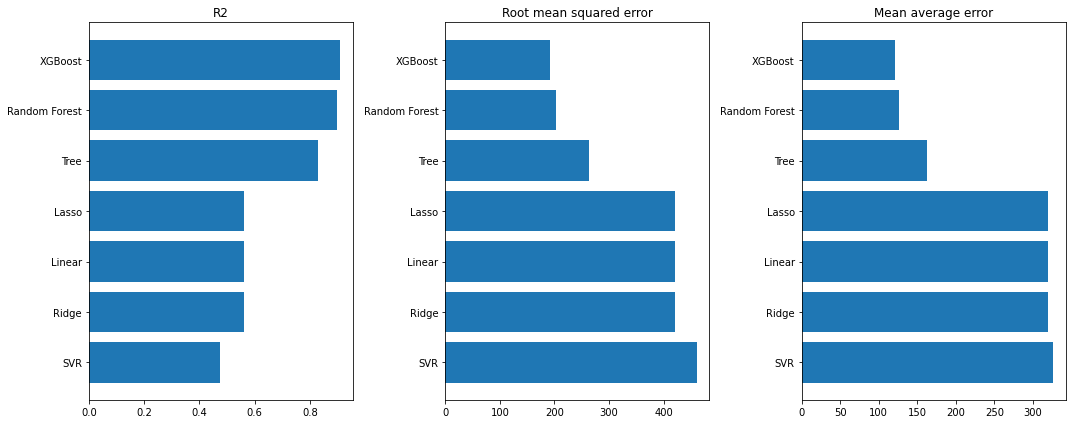

In [ ]:
regression_results = regression_results.sort_values(by='R2_test')
plt.subplots(1, 3, figsize=(15, 6))

plt.subplot(131)
plt.title('R2')
plt.barh(regression_results.index, regression_results['R2_test'])

plt.subplot(132)
plt.title('Root mean squared error')
plt.barh(regression_results.index, regression_results['MSE']**(1/2))

plt.subplot(133)
plt.title('Mean average error')
plt.barh(regression_results.index, regression_results['MAE'])

plt.tight_layout()
plt.show()

In order to understand which features were important or not we decided to use the random forest algorithm, which has a method for evaluating feature importance. This method tells us that the two most determinant features to determine if a person who would rent a bike decides to not rent it are the temperature and the time of day. It also shows us that we could've used data of approximately 6 dimensions without that much loss of prediction power. But considering the size of our dataset and the amount of features we had, we decided that reducing the dimensionality wasn't necessary this time. 

In [ ]:
%%capture
rf = RandomForestRegressor(max_depth=14,
                           min_samples_leaf=2,
                           min_samples_split=2)
rf.fit(X_train, y_train)

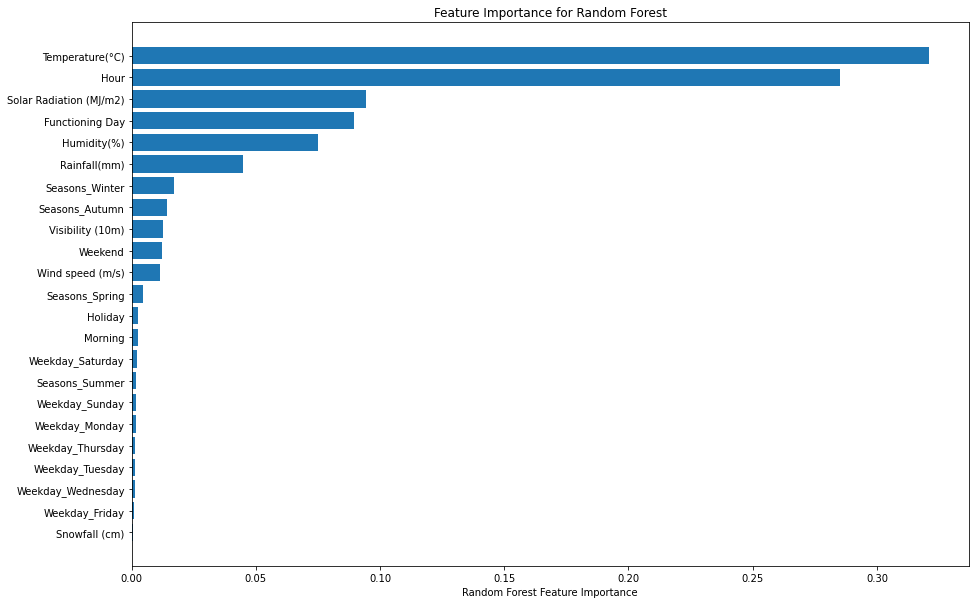

In [ ]:
plt.figure(figsize=(15,10))
sorted_feat = rf.feature_importances_.argsort()
plt.title('Feature Importance for Random Forest')
plt.barh(X.columns[sorted_feat], rf.feature_importances_[sorted_feat])
plt.xlabel("Random Forest Feature Importance")
plt.show()